In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
from pandas_profiling import ProfileReport
from sklearn.impute import KNNImputer
import seaborn as sns
data = pd.read_csv('./data/LBNL_file.csv', low_memory=False)


pd.options.display.max_columns = None

## Datan esikäsittely

Datasetissä on miljoona riviä ja 78 saraketta. Puuttuvat arvot merkattu arvolla -9999, joita on aineistossa kolmea eri datatyyppiä, int, float ja str(object). Muutetaan nämä kaikki NaN-muotoon, jotta datasetin käsittely olisi mielekkäämpää.

In [2]:
df = data.replace([-9999, '-9999', -9999.0], np.nan)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 78 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   data_provider_1                  1000000 non-null  object 
 1   data_provider_2                  221982 non-null   object 
 2   system_ID_1                      999895 non-null   object 
 3   system_ID_2                      222098 non-null   object 
 4   installation_date                1000000 non-null  object 
 5   system_size_DC                   988692 non-null   float64
 6   total_installed_price            814364 non-null   float64
 7   rebate_or_grant                  954632 non-null   float64
 8   customer_segment                 1000000 non-null  object 
 9   expansion_system                 1000000 non-null  int64  
 10  multiple_phase_system            1000000 non-null  int64  
 11  new_construction                 207044 non-null   

In [4]:
# puuttuvien arvojen osuus kaikista
nan_values = df.isna().sum().sum()
all_values = 78 * 1000000
print(nan_values / all_values)



0.5271942564102564


Puuttuvia arvoja on todella paljon, noin puolet kaikista arvoista. Kuitenkin kiinnostavimmissa sarakkeissa, kuten asennuspäivämäärä ja asiakassegmentti löytyvät kaikki arvot, sekä systeemien hinta- ja teho-sarakkeissa on suurin osa arvoista. 

Aineistossa on tietoja aurinkopaneelijärjestelmistä kolmen osavaltion alueelta, Kaliforniasta, Arizonasta ja Arkansasista. Tässä datasetissä Arizonan ja Arkansasin tietoja on vain murto-osa, noin 1000 riviä, joten ne voidaan pudottaa pois. Muiden osavaltioiden tietojen vähyyden vuoksi keskitytään tässä projektissa vain Kaliforniaan. 

Sarakkeista siivotaan selkeästi epäoleelliset tiedot, kuten sarjanumerot ja datalähteet. Sarjanumero on uniikki jokaisella rivillä, joten jos nämä muutetaan numeerisiksi koneoppimista varten, saadaan vain eri numerot jokaiselle riville(kuin indeksi). Koska aineisto on rajattu vain Kaliforniaan, datalähde(data_provider) on kaikissa riveissä sama. Myös osavaltiotieto voidaan nyt pudottaa. 




In [5]:
d = df.copy()
# vain kalifornia
d = d[d['state'] == "CA"]

# sarjanumerot, lähteet ja osavaltio
d.drop(columns=['data_provider_1', 'data_provider_2', 'system_ID_1', 'system_ID_2', 'state'] ,inplace=True)






In [6]:
# datetime-formaatti
d['installation_date'] = pd.to_datetime(d['installation_date'])


<AxesSubplot:>

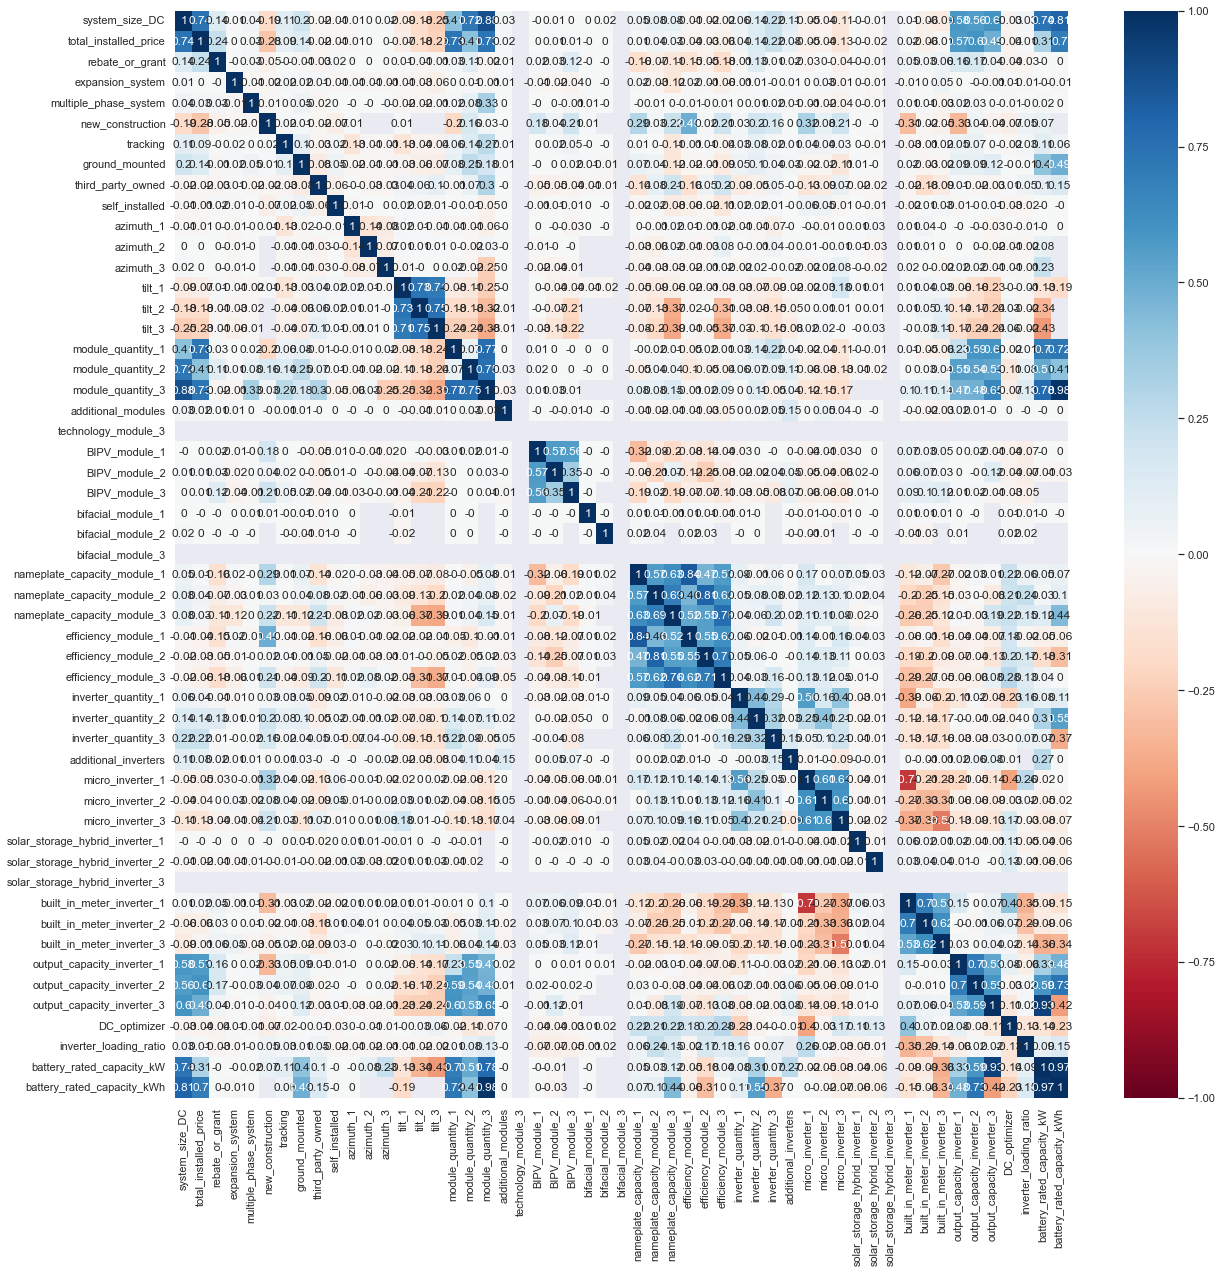

In [7]:
sns.set(rc={'figure.figsize':(20,20)})
corr = df.corr()
corr = corr.round(2)
sns.heatmap(corr, cmap='RdBu', vmin=-1, vmax=1, annot=True)

In [8]:
d.head()

,installation_date,system_size_DC,total_installed_price,rebate_or_grant,customer_segment,expansion_system,multiple_phase_system,new_construction,tracking,ground_mounted,zip_code,city,utility_service_territory,third_party_owned,installer_name,self_installed,azimuth_1,azimuth_2,azimuth_3,tilt_1,tilt_2,tilt_3,module_manufacturer_1,module_model_1,module_quantity_1,module_manufacturer_2,module_model_2,module_quantity_2,module_manufacturer_3,module_model_3,module_quantity_3,additional_modules,technology_module_1,technology_module_2,technology_module_3,BIPV_module_1,BIPV_module_2,BIPV_module_3,bifacial_module_1,bifacial_module_2,bifacial_module_3,nameplate_capacity_module_1,nameplate_capacity_module_2,nameplate_capacity_module_3,efficiency_module_1,efficiency_module_2,efficiency_module_3,inverter_manufacturer_1,inverter_model_1,inverter_quantity_1,inverter_manufacturer_2,inverter_model_2,inverter_quantity_2,inverter_manufacturer_3,inverter_model_3,inverter_quantity_3,additional_inverters,micro_inverter_1,micro_inverter_2,micro_inverter_3,solar_storage_hybrid_inverter_1,solar_storage_hybrid_inverter_2,solar_storage_hybrid_inverter_3,built_in_meter_inverter_1,built_in_meter_inverter_2,built_in_meter_inverter_3,output_capacity_inverter_1,output_capacity_inverter_2,output_capacity_inverter_3,DC_optimizer,inverter_loading_ratio,battery_rated_capacity_kW,battery_rated_capacity_kWh
105,2019-12-06,10.080367,30660.0,0.0,RES,0,0,NaN,0.0,0.0,92365,NEWBERRY SPRINGS,Southern California Edison,0.0,Palomar Solar,0.0,242.0,NaN,NaN,18.0,NaN,NaN,LG Electronics Inc.,LG320N1K-A5,25.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,Mono,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,320.0,NaN,NaN,0.194092,NaN,NaN,NaN,NaN,25.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
106,2019-12-05,9.000000,39648.0,0.0,RES,0,0,NaN,0.0,0.0,92029,ESCONDIDO,San Diego Gas and Electric,0.0,Sunline Energy,0.0,103.0,NaN,NaN,18.0,NaN,NaN,LG Electronics Inc.,LG360Q1C-A5,25.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,Mono,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,360.0,NaN,NaN,0.215146,NaN,NaN,Enphase Energy Inc.,IQ7PLUS-72-x-US [240V],25.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.290,NaN,NaN,0.0,1.241379,NaN,NaN
107,2019-12-02,15.180000,43263.0,0.0,RES,0,0,NaN,0.0,0.0,96019,SHASTA LAKE,Pacific Gas and Electric,0.0,Tesla Energy,0.0,182.0,NaN,NaN,24.0,NaN,NaN,SolarCity,SC330,46.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,Multi-c-Si,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,330.0,NaN,NaN,0.197101,NaN,NaN,SOLAREDGE TECHNOLOGIES LTD.,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
108,2019-12-12,5.180000,22345.0,0.0,RES,0,0,NaN,0.0,0.0,95066,SCOTTS VALLEY,Pacific Gas and Electric,0.0,Allterra Environmental,0.0,238.0,NaN,NaN,18.0,NaN,NaN,LG Electronics Inc.,LG370Q1C-V5,14.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,Mono,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,370.0,NaN,NaN,0.221123,NaN,NaN,ENPHASE ENERGY INC.,NaN,14.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.290,NaN,NaN,0.0,1.275862,NaN,NaN
109,2019-12-23,3.520000,21155.0,0.0,RES,0,0,NaN,0.0,0.0,92057,OCEANSIDE,San Diego Gas and Electric,1.0,Vivint Solar Developer,0.0,254.0,NaN,NaN,18.0,NaN,NaN,"Jinko Solar Co., Ltd",JKM320M-60HBL,11.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,Mono,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,320.0,NaN,NaN,0.197531,NaN,NaN,SolarEdge Technologies Ltd.,SE3800H-US [240V],1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,NaN,NaN,1.0,NaN,NaN,3.747,NaN,NaN,1.0,0.939418,NaN,NaN


Datasetissä yksi rivi vastaa siis yhtä aurinkopanelijärjestelmää. Yhdessä järjestelmässä voi olla useita eri tai saman valmistajan valmistamia aurinkopaneeleja, inverttereitä tai muita järjestelmän osia. Jos saman kategorian komponentteja on useita samassa järjestelmässä, ne on merkattu omaan sarakkeeseen. Tietoja on kerätty enintään kolmesta saman kategorian komponentista yhdessä järjestelmässä. Joissakin komponenteissa on vielä lisätieto, jos niitä on enemmän kuin 3. Valtaosassa aineiston järjestelmissä on vain yksi yksikkö kutakin komponenttia. 

Esimerkiksi:

In [9]:
df.iloc[120,27:37]

module_manufacturer_1       Hanwha Q CELLS
module_model_1           Q.PEAK DUO-G5 315
module_quantity_1                     49.0
module_manufacturer_2                  NaN
module_model_2                         NaN
module_quantity_2                      NaN
module_manufacturer_3                  NaN
module_model_3                         NaN
module_quantity_3                      NaN
additional_modules                     0.0
Name: 120, dtype: object

Järjestelmän hinta- ja tehotiedot ovat kuitenkin ilmoitettu koko järjestelmälle ja nämä tiedot ovat tässä projektissa oleellisimmat. Koska samankaltaista ja oletetusti ei niin oleellista tietoa on eri sarakkeissa paljon, yhdistetään samantyyppistä tietoa omiin sarakkeisiinsa. Tämän jälkeen datasetti on helpommin hahmotettavissa.

Tämä voi olla parempi tapa, kuin pudottaa sarakkeita kokonaan, jotta tietoa menetettäisiin mahdollisimma vähän.


In [10]:
# paneelien yhteenlaskettu määrä
d['module_quantity'] = d[['module_quantity_1','module_quantity_2','module_quantity_3']].sum(axis=1)

# järjestelmän paneelien hyötysuhteen keskiarvo
d['module_efficiency'] = d[['efficiency_module_1', 'efficiency_module_2',
       'efficiency_module_3']].mean(axis=1)

# Jos systeemissä on mikro-inverttereitä
d['micro_inverter'] = d[['micro_inverter_1', 'micro_inverter_2','micro_inverter_3']].sum(axis=1)
d.loc[d['micro_inverter'] > 0, 'micro_inverter'] = 1
# jos kaikki kolme sarakketta nan
d.loc[d[['micro_inverter_1', 'micro_inverter_2', 'micro_inverter_3']].isnull().all(axis=1),'micro_inverter']=np.nan


# Jos systeemissä on 'solar_storage_hybrid_inverter'
d['solar_storage_hybrid_inverter'] = d[['solar_storage_hybrid_inverter_1','solar_storage_hybrid_inverter_2', 'solar_storage_hybrid_inverter_3',]].sum(axis=1)
d.loc[d['solar_storage_hybrid_inverter'] > 0, 'solar_storage_hybrid_inverter'] = 1
# jos kaikki kolme saraketta nan
d.loc[d[['solar_storage_hybrid_inverter_1','solar_storage_hybrid_inverter_2', 'solar_storage_hybrid_inverter_3']].isnull().all(1),'solar_storage_hybrid_inverter']=np.nan


# Jos systeemissä on 'built_in_meter_inverter'
d['built_in_meter_inverter'] = d[['built_in_meter_inverter_1', 'built_in_meter_inverter_2','built_in_meter_inverter_3']].sum(axis=1)
d.loc[d['built_in_meter_inverter'] > 0, 'built_in_meter_inverter'] = 1
# jos kaikki kolme saraketta nan
d.loc[d[['built_in_meter_inverter_1', 'built_in_meter_inverter_2', 'built_in_meter_inverter_3']].isnull().all(axis=1),'built_in_meter_inverter']=np.nan


# Jos systeemissä on 'BIPV_module',
d['BIPV_module'] = d[['BIPV_module_1', 'BIPV_module_2', 'BIPV_module_3']].sum(axis=1)
d.loc[d['BIPV_module'] > 0, 'BIPV_module'] = 1
# jos kaikki kolme saraketta nan
d.loc[d[['BIPV_module_1','BIPV_module_2', 'BIPV_module_3']].isnull().all(axis=1),'BIPV_module']=np.nan


# Jos systeemissä on 'bifacial_module'
d['bifacial_module'] = d[['bifacial_module_1', 'bifacial_module_2', 'bifacial_module_3']].sum(axis=1)
d.loc[d['bifacial_module'] > 0, 'bifacial_module'] = 1
# jos kaikki kolme saraketta nan
d.loc[d[['bifacial_module_1','bifacial_module_2', 'bifacial_module_3']].isnull().all(axis=1),'bifacial_module']=np.nan
  
    
# nimellistehojen keskiarvo
d['nameplate_capacity'] = d[['nameplate_capacity_module_1',
       'nameplate_capacity_module_2', 'nameplate_capacity_module_3']].mean(axis=1)


# Invertterien määrä yhteensä
d['inverter_quantity'] = d[['inverter_quantity_1', 'inverter_quantity_2','inverter_quantity_3']].sum(axis=1)
# jos kaikki kolme saraketta nan
d.loc[d[['inverter_quantity_1', 'inverter_quantity_2','inverter_quantity_3']].isnull().all(axis=1),'inverter_quantity']=np.nan


# tilt-keskiarvo
d['tilt'] = d[['tilt_1','tilt_2', 'tilt_3']].mean(axis=1)

# suuntaus, tässä valtaosa datasta ensimmäisessä sarakkeessa ja esimerkikisi keskiarvon laskeminen ei järkevää
d['azimuth'] = d['azimuth_1']

# moduulin teknologia, tässä valtaosa datasta ensimmäisessä sarakkeessa ja technology_module_3 kokonaan NaN
d['technology_module'] = d['technology_module_1']



Invertterin tai useampien inverttereiden kokonaisteholle ei ole datasetissä saraketta, mutta järjestelmän ja invertterin tehon suhdeluku(inverter_loading_ratio) on ilmoitettu. Se on laskettu joko ilmoitettujen, tai arvioitujen arvojen perusteella. Tämän perusteella voidaan laskea invertterin koko, niissä järjestelmissä, joissa suhdeluku on ilmoitettu.
 

In [11]:
# Invertterin koko laskettuna inverter loading ration perusteella
d['inverter_total_capacity'] = d['system_size_DC'] /  d['inverter_loading_ratio']


Kolmasosa inverter_loading_ratio-sarakkeen puuttuu. Tavoitteena oli laskea puuttuvat arvot system_size_DC- ja output_capacity_inverter-sarakkeiden avulla. Tällä menetelmällä saatiin noin 70000 arvoa lisää, joista 50000 oli laskettu väärin. Vertasimme laskettuja arvoja alkuperäiseen ilmoitettuun arvoon ja kaava ei toiminut kaikissa tapauksissa. Todennäköisesti tämä johtui erilaisista ilmoituskäytönnöistä järjestelmien välillä ja datasetin kokoaja on ottanut huomioon tämän ja laskenut arvot niille riveille, jossa se on mahdollista.

``` df["inverter_loading_ratio2"] = df["system_size_DC"] / df["output_capacity_inverter"] ```


Asiakassegmentti jaetaan asuinkiinteistöihin asennettuihin järjestelmiin ja muihin järjestelmiin.

In [12]:
# residential = 1, non-residental = 0
d['residential'] = np.where(d['customer_segment'] == "RES", 1, 0)





Eritellään akulliset ja akuttomat järjestelmät. Järjestelmät, joissa on akku ovat suurempia, koska akuista saadaan enemmän hyötyä irti, jos järjestelmä tuottaa enemmän mitä kuluttaa.

In [13]:
d['battery'] = np.where((d['battery_rated_capacity_kW'] > 0) | (d['battery_rated_capacity_kWh'] > 0), 1, 0)


In [14]:
# Siivotaan yhdistetyt sarakkeet pois
d.drop(columns=[
       'module_quantity_1', 
       'module_quantity_2',
       'module_quantity_3', 'additional_modules','azimuth_1', 'azimuth_2', 'azimuth_3', 'tilt_1',
       'tilt_2', 'tilt_3','BIPV_module_1', 'technology_module_1', 'technology_module_2', 'technology_module_3',
       'BIPV_module_2', 'BIPV_module_3', 'BIPV_module','bifacial_module_1',
       'bifacial_module_2', 'bifacial_module_3', 'bifacial_module','inverter_manufacturer_1', 'inverter_model_1',
       'inverter_quantity_1', 'inverter_manufacturer_2', 'inverter_model_2',
       'inverter_quantity_2', 'inverter_manufacturer_3', 'inverter_model_3',
       'inverter_quantity_3', 'additional_inverters', 'micro_inverter_1',
       'micro_inverter_2','micro_inverter_2','micro_inverter_3', 'efficiency_module_1', 'efficiency_module_2',
       'efficiency_module_3',
        'solar_storage_hybrid_inverter_1','solar_storage_hybrid_inverter_2', 'solar_storage_hybrid_inverter_3', 'built_in_meter_inverter_1', 'built_in_meter_inverter_2',
       'built_in_meter_inverter_3','output_capacity_inverter_1',
       'output_capacity_inverter_2', 'output_capacity_inverter_3', 'nameplate_capacity_module_1',
       'nameplate_capacity_module_2', 'nameplate_capacity_module_3', 'customer_segment', 'battery_rated_capacity_kWh'], inplace=True)





In [15]:
d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 998971 entries, 105 to 999075
Data columns (total 37 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   installation_date              998971 non-null  datetime64[ns]
 1   system_size_DC                 987664 non-null  float64       
 2   total_installed_price          813366 non-null  float64       
 3   rebate_or_grant                953631 non-null  float64       
 4   expansion_system               998971 non-null  int64         
 5   multiple_phase_system          998971 non-null  int64         
 6   new_construction               207044 non-null  float64       
 7   tracking                       899359 non-null  float64       
 8   ground_mounted                 759359 non-null  float64       
 9   zip_code                       998971 non-null  object        
 10  city                           998971 non-null  object        
 11

<AxesSubplot:>

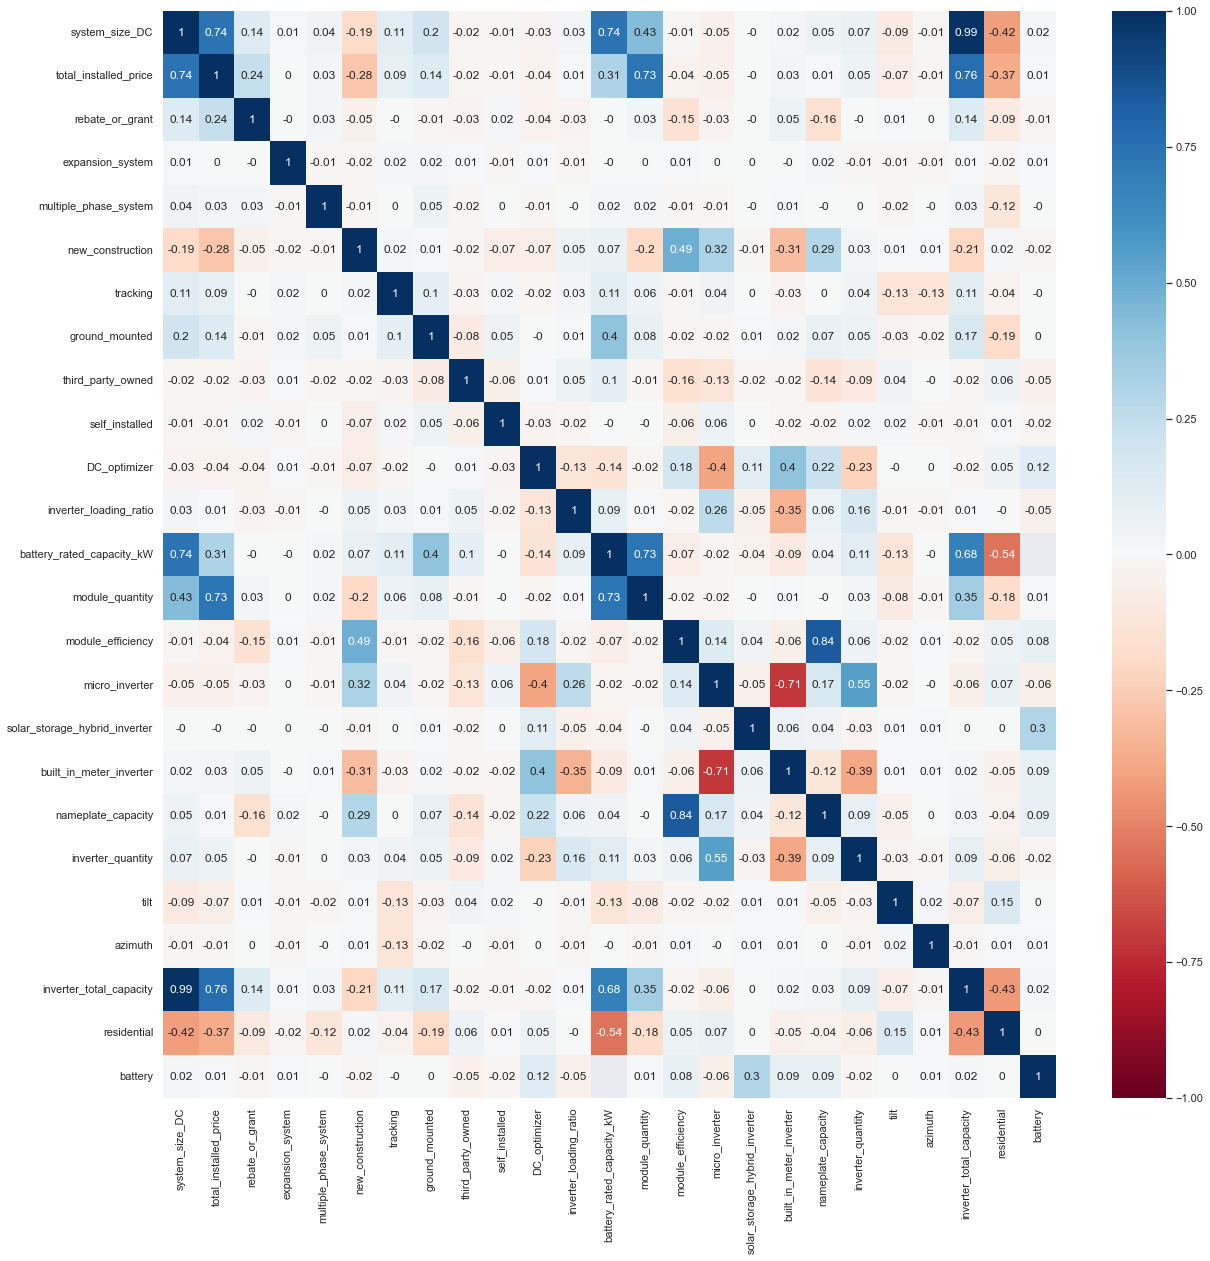

In [16]:
sns.set(rc={'figure.figsize':(20,20)})
corr = d.corr()
corr = corr.round(2)
sns.heatmap(corr, cmap='RdBu', vmin=-1, vmax=1, annot=True)

Nyt datasetissä on 998971 riviä ja sarakkeiden määrä on tippunut 38:aan. Datasetti nyt helpommn hahmotettavissa ja korrelaatio säilyy. 

### Koneoppiminen

In [17]:
df2 = d.copy()
df2.drop(columns=['new_construction', 'city', 'utility_service_territory', 'module_manufacturer_2', 'module_model_2',
       'module_manufacturer_3', 'module_model_3'], inplace=True)

In [18]:


df2 = df2[df2['total_installed_price'].notna()]
df2 = df2[df2['system_size_DC'].notna()]
df2 = df2[df2['rebate_or_grant'].notna()]
df2 = df2[df2['inverter_total_capacity'].notna()]


In [19]:


def fill_mode(cols):
    for col in cols:
        
        num = df2[col].mode()[0]
        df2[col].fillna(num, inplace=True)
    
cols = ['tracking', 'ground_mounted', 
        'third_party_owned' ,'self_installed', 
        'installer_name', 'module_manufacturer_1', 
        'module_model_1', 'DC_optimizer', 'solar_storage_hybrid_inverter', 'built_in_meter_inverter', 'azimuth', 'technology_module'] 


fill_mode(cols)


num = df2['module_efficiency'].mean()
df2['module_efficiency'].fillna(num, inplace=True)


num = df2['nameplate_capacity'].mean()
df2['nameplate_capacity'].fillna(num, inplace=True)

num = df2['tilt'].mean()
df2['tilt'].fillna(num, inplace=True)


df2['zip_code'] = df2['zip_code'].astype(int)

#df2 = df2[df2['rebate_or_grant'].notna()]

df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 602955 entries, 106 to 999075
Data columns (total 30 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   installation_date              602955 non-null  datetime64[ns]
 1   system_size_DC                 602955 non-null  float64       
 2   total_installed_price          602955 non-null  float64       
 3   rebate_or_grant                602955 non-null  float64       
 4   expansion_system               602955 non-null  int64         
 5   multiple_phase_system          602955 non-null  int64         
 6   tracking                       602955 non-null  float64       
 7   ground_mounted                 602955 non-null  float64       
 8   zip_code                       602955 non-null  int64         
 9   third_party_owned              602955 non-null  float64       
 10  installer_name                 602955 non-null  object        
 11

In [20]:
from sklearn.preprocessing import LabelEncoder

# creating instance of labelencoder
labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column

df3 = df2.copy()


df3['installer_name'] = labelencoder.fit_transform(df3['installer_name'])
df3['module_manufacturer_1'] = labelencoder.fit_transform(df3['module_manufacturer_1'])
df3['module_model_1'] = labelencoder.fit_transform(df3['module_model_1'])
df3['technology_module'] = labelencoder.fit_transform(df3['technology_module'])

df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 602955 entries, 106 to 999075
Data columns (total 30 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   installation_date              602955 non-null  datetime64[ns]
 1   system_size_DC                 602955 non-null  float64       
 2   total_installed_price          602955 non-null  float64       
 3   rebate_or_grant                602955 non-null  float64       
 4   expansion_system               602955 non-null  int64         
 5   multiple_phase_system          602955 non-null  int64         
 6   tracking                       602955 non-null  float64       
 7   ground_mounted                 602955 non-null  float64       
 8   zip_code                       602955 non-null  int64         
 9   third_party_owned              602955 non-null  float64       
 10  installer_name                 602955 non-null  int64         
 11

<AxesSubplot:>

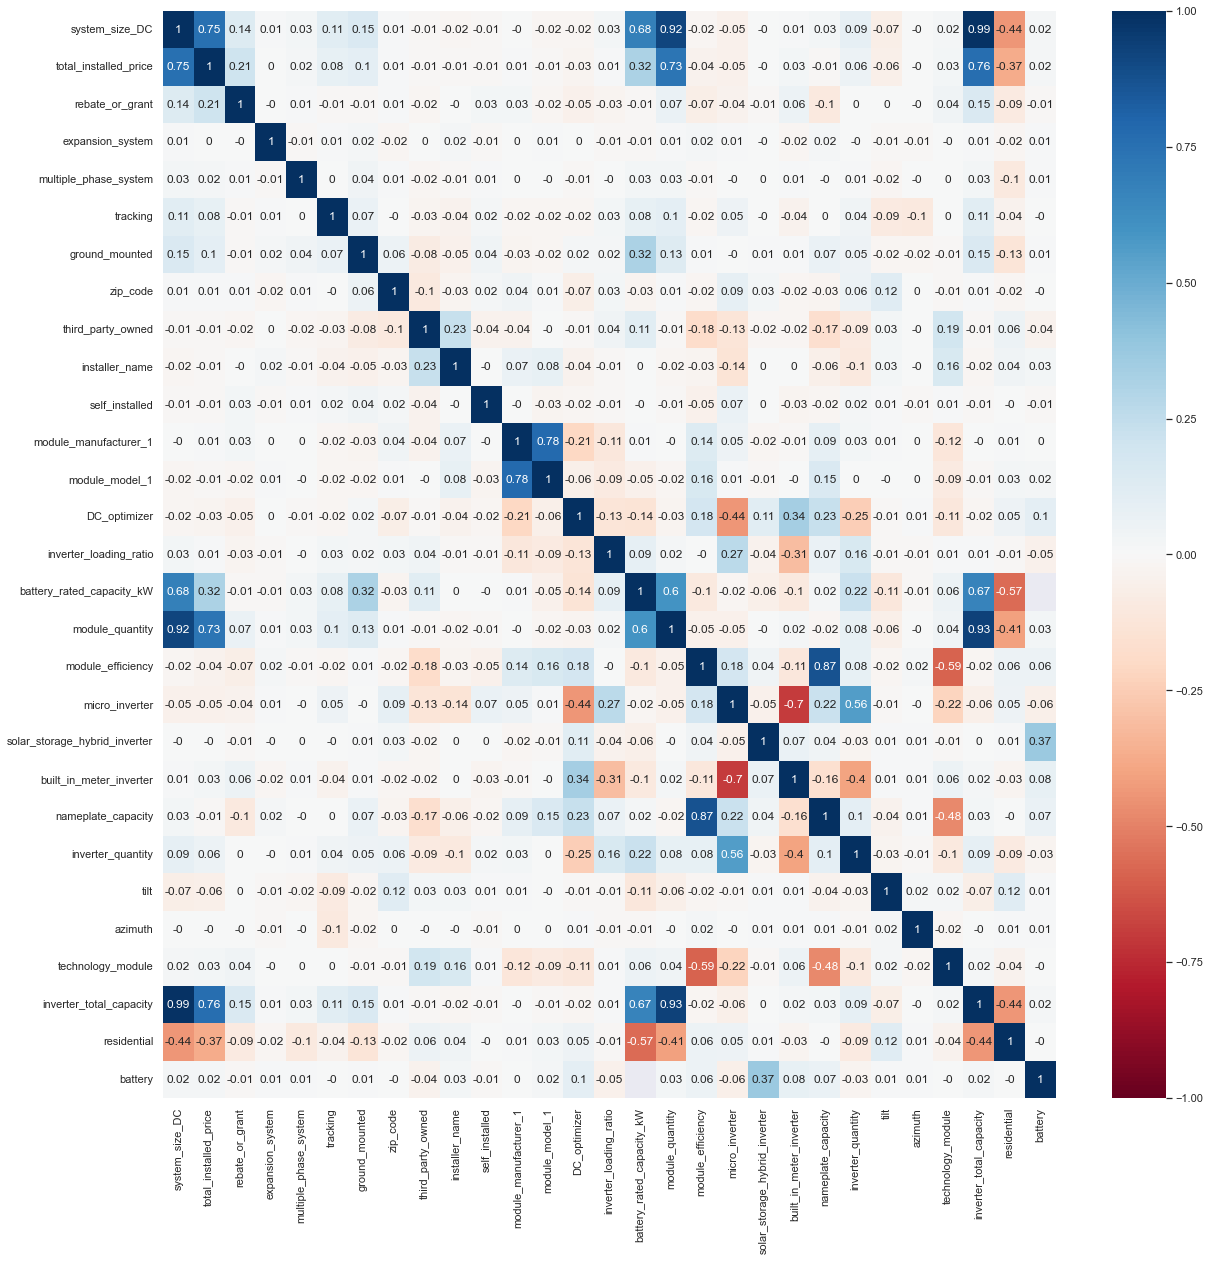

In [21]:
sns.set(rc={'figure.figsize':(20,20)})
corr = df3.corr()
corr = corr.round(2)
sns.heatmap(corr, cmap='RdBu', vmin=-1, vmax=1, annot=True)

In [25]:
df4 = df3.copy()


res = df4[(df4['residential'] == 1) & (df4['battery'] == 0)]
res_bat = df4[(df4['residential'] == 1) & (df4['battery'] == 1)]

non_res = df4[(df4['residential'] == 0) & (df4['battery'] == 0)]
non_res_bat = df4[(df4['residential'] == 0) & (df4['battery'] == 1)]


res = res.drop(columns=['battery', 'battery_rated_capacity_kW', 'residential'])
res_bat = res_bat.drop(columns=['battery', 'residential'])
non_res = non_res.drop(columns=['battery', 'battery_rated_capacity_kW', 'residential'])
non_res_bat = non_res_bat.drop(columns=['battery', 'residential'])

#res_price_per_kw = res['total_installed_price'] / res['system_size_DC']
#res_avg_price_per_kw = res_price_per_kw.mean()
#res['total_installed_price'].fillna(round(res_avg_price_per_kw * res['system_size_DC'], 2) , inplace=True)


non_res.info()





<class 'pandas.core.frame.DataFrame'>
Int64Index: 11243 entries, 130 to 999064
Data columns (total 27 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   installation_date              11243 non-null  datetime64[ns]
 1   system_size_DC                 11243 non-null  float64       
 2   total_installed_price          11243 non-null  float64       
 3   rebate_or_grant                11243 non-null  float64       
 4   expansion_system               11243 non-null  int64         
 5   multiple_phase_system          11243 non-null  int64         
 6   tracking                       11243 non-null  float64       
 7   ground_mounted                 11243 non-null  float64       
 8   zip_code                       11243 non-null  int64         
 9   third_party_owned              11243 non-null  float64       
 10  installer_name                 11243 non-null  int64         
 11  self_install

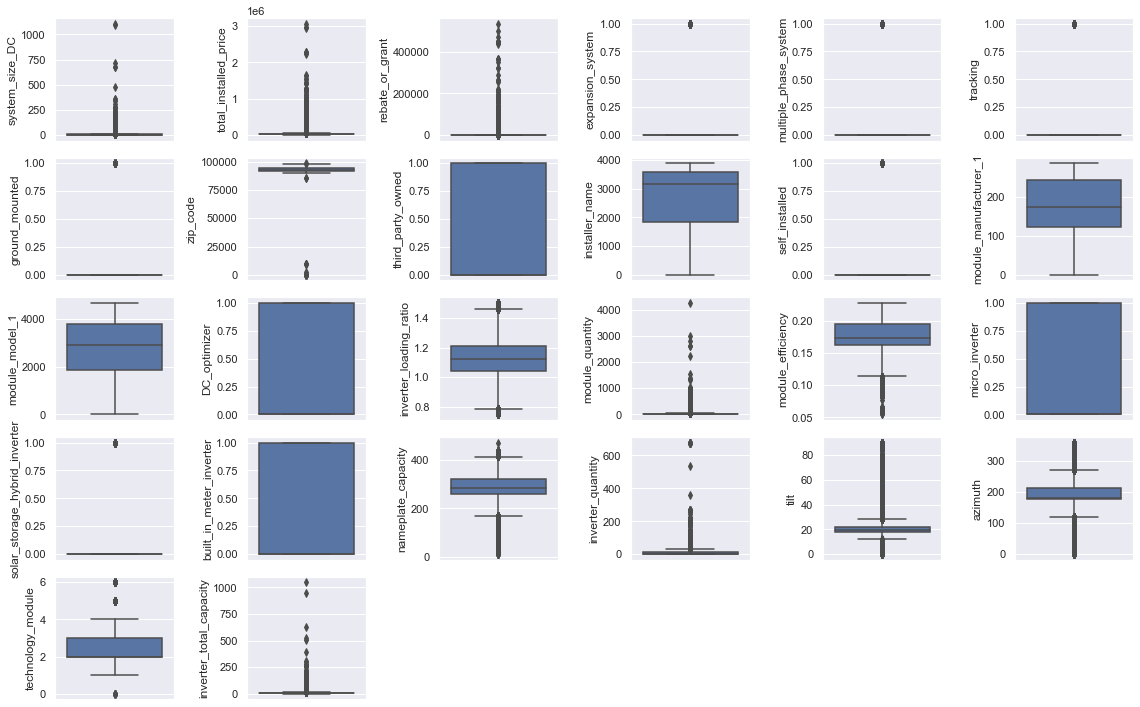

In [27]:
plt.figure(figsize=(16,10))
features = res.columns.to_list()[1:]
for i,col in enumerate(features):    
    plt.subplot(5,6,i + 1)
    sns.boxplot(y=col, data=res)
    #plt.ylabel('')
plt.tight_layout()
plt.show()

In [30]:
def IQR_Outliers (X, features):
    print('# of features: ', len(features))
    print('Features: ', features)
    indices = [x for x in X.index]
    #print(indices)
    print('Number of samples: ', len(indices))
    
    out_indexlist = []
        
    for col in features:
       
        #Using nanpercentile instead of percentile because of nan values
        Q1 = np.nanpercentile(X[col], 25.)
        Q3 = np.nanpercentile(X[col], 75.)
        
        cut_off = (Q3 - Q1) * 1.5
        upper, lower = Q3 + cut_off, Q1 - cut_off
        print ('\nFeature: ', col)
        print ('Upper and Lower limits: ', upper, lower)
                
        outliers_index = X[col][(X[col] < lower) | (X[col] > upper)].index.tolist()
        outliers = X[col][(X[col] < lower) | (X[col] > upper)].values
        print('Number of outliers: ', len(outliers))
        #print('Outliers Index: ', outliers_index)
        #print('Outliers: ', outliers)
        
        out_indexlist.extend(outliers_index)
        
    #using set to remove duplicates
    out_indexlist = list(set(out_indexlist))
    out_indexlist.sort()
    print('\nNumber of rows with outliers: ', len(out_indexlist))
    print('List of rows with outliers: ', out_indexlist)
    
    
IQR_Outliers(res, features)

# of features:  26
Features:  ['system_size_DC', 'total_installed_price', 'rebate_or_grant', 'expansion_system', 'multiple_phase_system', 'tracking', 'ground_mounted', 'zip_code', 'third_party_owned', 'installer_name', 'self_installed', 'module_manufacturer_1', 'module_model_1', 'DC_optimizer', 'inverter_loading_ratio', 'module_quantity', 'module_efficiency', 'micro_inverter', 'solar_storage_hybrid_inverter', 'built_in_meter_inverter', 'nameplate_capacity', 'inverter_quantity', 'tilt', 'azimuth', 'technology_module', 'inverter_total_capacity']
Number of samples:  585458

Feature:  system_size_DC
Upper and Lower limits:  13.17 -1.4700000000000006
Number of outliers:  16635

Feature:  total_installed_price
Upper and Lower limits:  59500.0 -8500.0
Number of outliers:  20816

Feature:  rebate_or_grant
Upper and Lower limits:  2177.5 -1306.5
Number of outliers:  82019

Feature:  expansion_system
Upper and Lower limits:  0.0 0.0
Number of outliers:  4928

Feature:  multiple_phase_system
Uppe